**Import Libraries**

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

#Import Model Packages 
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import inv, eig, svd
import warnings
warnings.filterwarnings('ignore')

**Load Data**

In [2]:
dataset = read_csv('dow.csv',index_col=0)
print(dataset.shape)
#4804 dates, 30 stocks
set_option('display.width', 100)
dataset.head(5)

(4804, 30)


,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,DWDP,...,NKE,PFE,PG,TRV,UTX,UNH,VZ,V,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,29.847043,35.476634,3.530576,26.650218,14.560887,21.582046,43.003876,16.983583,23.522220,NaN,...,4.701180,16.746856,32.227726,20.158885,21.319030,5.841355,22.564221,NaN,47.337599,21.713237
2000-01-04,28.661131,34.134275,3.232839,26.610431,14.372251,21.582046,40.577200,17.040950,24.899860,NaN,...,4.445214,16.121738,31.596399,19.890099,20.445803,5.766368,21.833915,NaN,45.566248,20.907354
2000-01-05,30.122175,33.959430,3.280149,28.473758,14.914205,22.049145,40.895453,17.228147,25.781550,NaN,...,4.702157,16.415912,31.325831,20.085579,20.254784,5.753327,22.564221,NaN,44.503437,21.097421
2000-01-06,31.877325,33.959430,2.996290,28.553331,15.459153,22.903343,39.781569,17.210031,24.899860,NaN,...,4.677733,16.972739,32.438168,20.122232,20.998392,5.964159,22.449405,NaN,45.126952,20.527220
2000-01-07,32.509812,34.433913,3.138219,29.382213,15.962182,23.305926,42.128682,18.342270,24.506249,NaN,...,4.677733,18.123166,35.023602,20.922479,21.830687,6.662948,22.282692,NaN,48.535033,21.051805


**Data Cleaning**

In [3]:
missing = dataset.isnull().mean().sort_values(ascending=False)
print(missing)
drop_list = sorted(list(missing[missing > 0.3].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)

# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')

# Drop the rows containing NA
dataset= dataset.dropna(axis=0)
print(dataset.shape)

# Daily Linear Returns (%)
datareturns = dataset.pct_change(1)

#Keep data within 3 standard deviation
datareturns = datareturns[datareturns.apply(lambda x :(x-x.mean()).abs()<(3*x.std()) ).all(1)]

DWDP    0.924438
V       0.429434
MMM     0.000000
JPM     0.000000
WMT     0.000000
VZ      0.000000
UNH     0.000000
UTX     0.000000
TRV     0.000000
PG      0.000000
PFE     0.000000
NKE     0.000000
MSFT    0.000000
MRK     0.000000
MCD     0.000000
JNJ     0.000000
AXP     0.000000
INTC    0.000000
IBM     0.000000
HD      0.000000
GS      0.000000
XOM     0.000000
DIS     0.000000
KO      0.000000
CSCO    0.000000
CVX     0.000000
CAT     0.000000
BA      0.000000
AAPL    0.000000
WBA     0.000000
dtype: float64
(4804, 28)


In [4]:
dataset.head(5)

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,29.847043,35.476634,3.530576,26.650218,14.560887,21.582046,43.003876,16.983583,23.522220,23.862240,...,38.135101,4.701180,16.746856,32.227726,20.158885,21.319030,5.841355,22.564221,47.337599,21.713237
2000-01-04,28.661131,34.134275,3.232839,26.610431,14.372251,21.582046,40.577200,17.040950,24.899860,23.405167,...,36.846046,4.445214,16.121738,31.596399,19.890099,20.445803,5.766368,21.833915,45.566248,20.907354
2000-01-05,30.122175,33.959430,3.280149,28.473758,14.914205,22.049145,40.895453,17.228147,25.781550,24.569179,...,37.235380,4.702157,16.415912,31.325831,20.085579,20.254784,5.753327,22.564221,44.503437,21.097421
2000-01-06,31.877325,33.959430,2.996290,28.553331,15.459153,22.903343,39.781569,17.210031,24.899860,25.958680,...,35.988857,4.677733,16.972739,32.438168,20.122232,20.998392,5.964159,22.449405,45.126952,20.527220
2000-01-07,32.509812,34.433913,3.138219,29.382213,15.962182,23.305926,42.128682,18.342270,24.506249,25.882501,...,36.459983,4.677733,18.123166,35.023602,20.922479,21.830687,6.662948,22.282692,48.535033,21.051805


In [5]:
datareturns.head(5)

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-11,-0.017595,0.009056,-0.051151,-0.015793,-0.015710,-0.009331,-0.030055,0.034008,0.010312,0.011940,...,-0.025657,0.050113,-0.001742,0.016393,-0.011299,-0.023209,0.002158,-0.009402,-0.014870,0.039649
2000-01-20,-0.037243,0.016790,0.065128,-0.023725,-0.044210,-0.005003,0.000890,0.009655,-0.032230,-0.021856,...,-0.009346,-0.023670,-0.016486,-0.024263,-0.005486,-0.022739,0.025210,0.003123,-0.010615,0.000000
2000-02-02,-0.017316,-0.028402,-0.014364,0.020114,0.005788,-0.006732,-0.033107,-0.030105,0.034722,0.007453,...,-0.020692,0.016063,-0.027027,-0.008744,-0.048789,0.001118,0.026451,-0.004197,-0.005282,0.004512
2000-02-03,-0.008757,-0.007917,0.045542,-0.026664,-0.026013,-0.014402,0.034241,-0.020043,0.016913,-0.017062,...,0.027874,0.009275,-0.010278,-0.008314,-0.044835,-0.015070,-0.008948,-0.014669,0.000000,-0.002073
2000-02-04,-0.028684,-0.009208,0.045397,0.012891,0.000000,-0.035363,0.028014,0.018100,0.006600,-0.018208,...,0.028373,-0.024854,0.003368,-0.031285,0.004506,-0.029467,0.024738,0.002053,-0.035457,0.010734


**Standardization (mean = 0, var = 1)**

In [6]:
scaler = StandardScaler().fit(datareturns)
rescaledDataset = pd.DataFrame(scaler.fit_transform(datareturns),columns = datareturns.columns, index = datareturns.index)
# summarize transformed data
datareturns.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)
rescaledDataset.head(5)

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-11,-1.713383,0.565603,-2.707674,-1.133045,-1.041247,-0.787063,-1.834413,3.568833,0.725353,0.981056,...,-1.936268,3.666524,-0.172523,1.771791,-0.936081,-1.954189,0.076018,-0.836288,-1.374665,2.942150
2000-01-20,-3.564118,1.077343,3.304005,-1.670108,-2.833568,-0.445782,0.021934,0.987042,-2.415069,-1.897394,...,-0.733208,-1.816361,-1.420880,-2.741513,-0.475716,-1.915682,1.653794,0.241016,-0.987037,-0.035748
2000-02-02,-1.687118,-1.912847,-0.805771,1.298353,0.310731,-0.582071,-2.017516,-3.228199,2.527273,0.598855,...,-1.570041,1.136259,-2.313315,-1.018676,-3.904924,0.036634,1.738736,-0.388661,-0.501179,0.303155
2000-02-03,-0.880834,-0.557421,2.291412,-1.869126,-1.689184,-1.186951,2.022552,-2.161418,1.212601,-1.489120,...,2.012015,0.631795,-0.895207,-0.970962,-3.591816,-1.288092,-0.684070,-1.289310,-0.019975,-0.191463
2000-02-04,-2.757847,-0.642837,2.283936,0.809265,-0.053288,-2.840078,1.649006,1.882288,0.451311,-1.586717,...,2.048796,-1.904348,0.260134,-3.520991,0.315593,-2.466351,1.621495,0.148985,-3.250242,0.770448


In [7]:
set_option('precision', 3)
rescaledDataset.describe()

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,MSFT,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA
count,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,...,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3.892e+03,3892.000,3.892e+03,3.892e+03,3.892e+03
mean,-2.373e-17,9.128e-18,4.564e-18,-1.369e-17,-2.328e-17,1.369e-17,2.191e-17,-2.465e-17,-2.191e-17,-2.465e-17,...,3.104e-17,2.191e-17,5.477e-18,-1.187e-17,-2.099e-17,-1.826e-17,0.000,-1.826e-18,-1.095e-17,1.095e-17
std,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,...,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000,1.000e+00,1.000e+00,1.000e+00
min,-3.924e+00,-4.357e+00,-3.726e+00,-3.698e+00,-3.688e+00,-3.796e+00,-4.359e+00,-4.013e+00,-4.054e+00,-3.821e+00,...,-4.228e+00,-3.940e+00,-3.900e+00,-4.096e+00,-4.302e+00,-3.814e+00,-3.964,-3.993e+00,-3.998e+00,-3.807e+00
25%,-5.513e-01,-4.935e-01,-5.312e-01,-5.965e-01,-5.685e-01,-5.927e-01,-4.946e-01,-5.581e-01,-5.459e-01,-5.930e-01,...,-5.606e-01,-5.735e-01,-5.639e-01,-5.583e-01,-5.452e-01,-5.682e-01,-0.562,-5.844e-01,-5.611e-01,-5.998e-01
50%,1.367e-03,-7.736e-03,-2.331e-02,-1.092e-02,-1.676e-02,1.636e-02,2.489e-03,9.481e-03,1.870e-03,-1.357e-02,...,-2.632e-02,-1.473e-02,-2.502e-02,-1.429e-02,-4.608e-04,-1.033e-02,-0.017,1.146e-02,2.637e-04,-2.222e-02
75%,5.882e-01,5.269e-01,5.397e-01,6.064e-01,5.788e-01,6.062e-01,5.403e-01,5.580e-01,5.583e-01,5.962e-01,...,5.520e-01,5.539e-01,5.648e-01,5.458e-01,5.461e-01,5.624e-01,0.562,5.786e-01,5.573e-01,5.889e-01
max,3.949e+00,4.324e+00,3.924e+00,3.803e+00,3.808e+00,3.714e+00,4.320e+00,4.044e+00,4.043e+00,3.721e+00,...,4.127e+00,4.057e+00,3.870e+00,4.172e+00,4.317e+00,3.982e+00,4.003,3.753e+00,4.100e+00,3.757e+00


**Train Test Split 80-20**

In [8]:
# Dividing the dataset into training and testing sets
percentage = int(len(rescaledDataset) * 0.8)
X_train = rescaledDataset[:percentage]
X_test = rescaledDataset[percentage:]

X_train_raw = datareturns[:percentage]
X_test_raw = datareturns[percentage:]


stock_tickers = rescaledDataset.columns.values
print(stock_tickers)
n_tickers = len(stock_tickers)

['MMM' 'AXP' 'AAPL' 'BA' 'CAT' 'CVX' 'CSCO' 'KO' 'DIS' 'XOM' 'GS' 'HD'
 'IBM' 'INTC' 'JNJ' 'JPM' 'MCD' 'MRK' 'MSFT' 'NKE' 'PFE' 'PG' 'TRV' 'UTX'
 'UNH' 'VZ' 'WMT' 'WBA']


**PCA**

In [9]:
pca = PCA()
PrincipalComponent=pca.fit(X_train)

print(pca.components_[0])
len(pca.components_)

[-0.2278224  -0.22835766 -0.15302828 -0.18969933 -0.20200012 -0.17810558
 -0.19508121 -0.16845303 -0.20820442 -0.19308548 -0.20879404 -0.20231768
 -0.19939638 -0.19521427 -0.16686975 -0.22806024 -0.15153408 -0.169941
 -0.19367262 -0.17118841 -0.18993347 -0.16805969 -0.197612   -0.22658993
 -0.13821257 -0.16688803 -0.16897835 -0.16070821]


28

**Explained Variance**

,Explained Variance
0,37.03%
1,42.75%
2,47.10%
3,51.08%
4,54.60%
5,57.74%
6,60.65%
7,63.44%
8,66.18%
9,68.71%


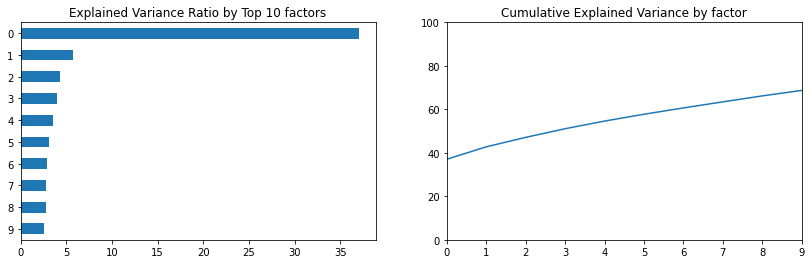

In [10]:
NumEigenvalues=10
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
Series1 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).sort_values()*100
Series2 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).cumsum()*100
Series1.plot.barh(ylim=(0,9), label="woohoo",title='Explained Variance Ratio by Top 10 factors',ax=axes[0]);
Series2.plot(ylim=(0,100),xlim=(0,9),ax=axes[1], title='Cumulative Explained Variance by factor');
# explained_variance
pd.Series(np.cumsum(pca.explained_variance_ratio_)).to_frame('Explained Variance').head(NumEigenvalues).style.format('{:,.2%}'.format)

**Portfolio Weights**

In [11]:
def PCWeights():
    weights = pd.DataFrame()
    print(pca.components_[0])
    print(sum(pca.components_[0]))
    for i in range(len(pca.components_)):
      weights[i] = pca.components_[i] / sum(pca.components_[i])
    weights = weights.values.T
    return weights

weights=PCWeights()

[-0.2278224  -0.22835766 -0.15302828 -0.18969933 -0.20200012 -0.17810558
 -0.19508121 -0.16845303 -0.20820442 -0.19308548 -0.20879404 -0.20231768
 -0.19939638 -0.19521427 -0.16686975 -0.22806024 -0.15153408 -0.169941
 -0.19367262 -0.17118841 -0.18993347 -0.16805969 -0.197612   -0.22658993
 -0.13821257 -0.16688803 -0.16897835 -0.16070821]
-5.247808242068631


In [12]:
NumComponents=5
        
topPortfolios = pd.DataFrame(pca.components_[:NumComponents], columns=dataset.columns)
eigen_portfolios = topPortfolios.div(topPortfolios.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range( NumComponents)]
np.sqrt(pca.explained_variance_)
eigen_portfolios.T
#.plot.bar(subplots=True, layout=(int(NumComponents),1), figsize=(14,10), legend=True, sharey=True, ylim= (-1,1))

,Portfolio 0,Portfolio 1,Portfolio 2,Portfolio 3,Portfolio 4
MMM,0.043,0.083,-0.646,-0.083,0.800
AXP,0.044,-0.315,-0.036,-1.196,-1.098
AAPL,0.029,-1.149,0.263,1.173,0.290
BA,0.036,-0.043,-0.780,-0.504,1.030
CAT,0.038,-0.292,-1.338,-0.178,0.947
CVX,0.034,0.443,-2.483,0.876,0.305
CSCO,0.037,-1.235,0.593,0.906,-0.306
KO,0.032,0.849,0.634,0.604,0.872
DIS,0.040,-0.313,0.262,-0.232,-0.075
XOM,0.037,0.518,-2.259,1.012,0.306


**Sharpe Ratio**

In [13]:
# Sharpe Ratio
def sharpe_ratio(df, days_per_year=252):
    year = df.shape[0]/days_per_year

    annualized_return = np.power(np.prod(1+df),(1/year))-1

    annualized_vol = df.std() * np.sqrt(days_per_year)

    annualized_sharpe = annualized_return / annualized_vol

    return (annualized_return, annualized_vol, annualized_sharpe)

**Find Optimized Portfolio**

Eigen portfolio #0 with the highest Sharpe. Return 11.47%, vol = 13.31%, Sharpe = 0.86
    Return    Vol  Sharpe
0    0.115  0.133   0.862
7    0.096  0.693   0.138
5    0.100  0.845   0.118
1    0.057  0.670   0.084
2   -0.107  0.859  -0.124
11  -1.000  7.228  -0.138
13  -0.399  2.070  -0.193
25  -1.000  5.009  -0.200
23  -1.000  4.955  -0.202
6   -0.416  1.967  -0.212
10  -0.158  0.738  -0.213
3   -0.162  0.738  -0.220
26  -1.000  4.535  -0.220
8   -0.422  1.397  -0.302
17  -0.998  3.277  -0.305
24  -0.550  1.729  -0.318
16  -0.980  3.038  -0.323
21  -0.470  1.420  -0.331
14  -0.886  2.571  -0.345
27  -0.933  2.606  -0.358


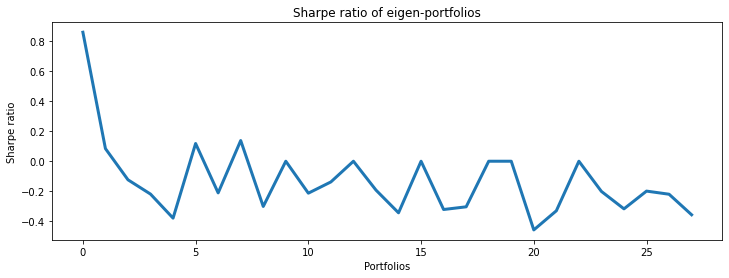

In [14]:
def optimizedPortfolio():
    n_portfolios = len(pca.components_)
    annualized_ret = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)
    annualized_vol = np.array([0.] * n_portfolios)
    highest_sharpe = 0 
    stock_tickers = rescaledDataset.columns.values
    n_tickers = len(stock_tickers)
    pcs = pca.components_
    
    for i in range(n_portfolios):
        
        pc_w = pcs[i] / sum(pcs[i])
        # each pc weights * 100, give stock code as index, and sort descending
        eigen_port = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
        eigen_port.sort_values(by=['weights'], ascending=False, inplace=True)

        # X_train_raw = datareturns[:percentage]
        # sort stock returns based on its weight, dot each returns with its weight, give date as index
        eigen_port_returns = np.dot(X_train_raw.loc[:, eigen_port.index], pc_w)
        eigen_port_returns = pd.Series(eigen_port_returns.squeeze(), index=X_train_raw.index)

        er, vol, sharpe = sharpe_ratio(eigen_port_returns)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe
        sharpe_metric = np.nan_to_num(sharpe_metric)
        
    # find portfolio with the highest Sharpe ratio
    highest_sharpe = np.argmax(sharpe_metric)

    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100, 
           annualized_vol[highest_sharpe]*100, 
           sharpe_metric[highest_sharpe]))


    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

    results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
    results.dropna(inplace=True)
    results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
    print(results.head(20))

    plt.show()

optimizedPortfolio()

**Current Eigen Portfolio Weights**

[-0.2278224  -0.22835766 -0.15302828 -0.18969933 -0.20200012 -0.17810558
 -0.19508121 -0.16845303 -0.20820442 -0.19308548 -0.20879404 -0.20231768
 -0.19939638 -0.19521427 -0.16686975 -0.22806024 -0.15153408 -0.169941
 -0.19367262 -0.17118841 -0.18993347 -0.16805969 -0.197612   -0.22658993
 -0.13821257 -0.16688803 -0.16897835 -0.16070821]
-5.247808242068631
Sum of weights of current eigen-portfolio: 100.00


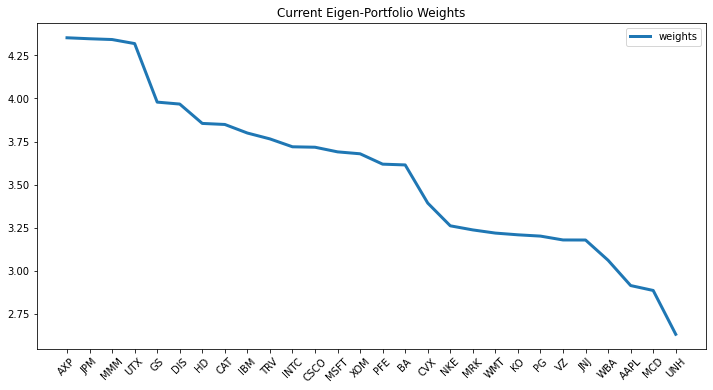

Sum of weights of current eigen-portfolio: 100.00


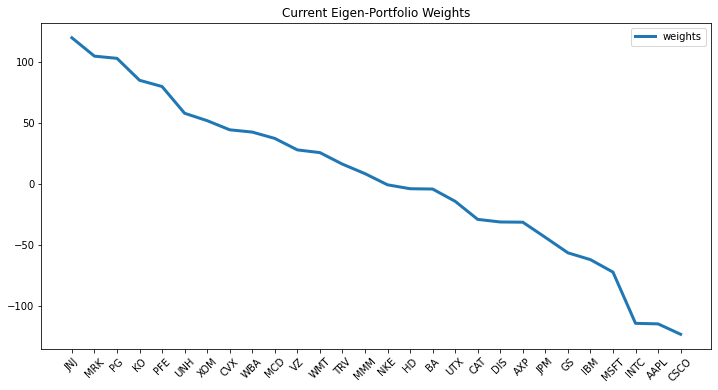

Sum of weights of current eigen-portfolio: 100.00


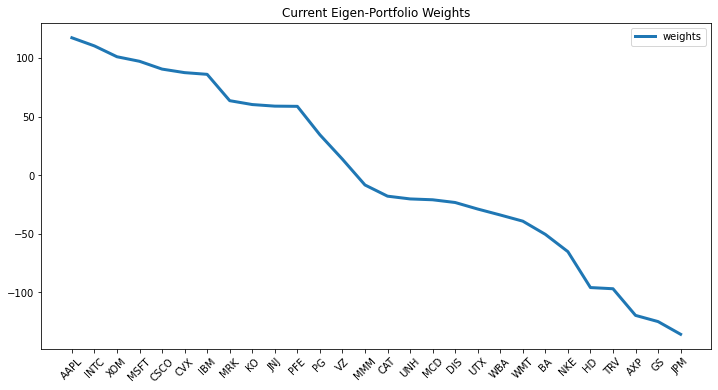

,weights
AAPL,117.347
INTC,110.392
XOM,101.153
MSFT,97.271
CSCO,90.615
CVX,87.599
IBM,86.145
MRK,63.667
KO,60.358
JNJ,59.004


In [15]:
weights = PCWeights()
portfolio = portfolio = pd.DataFrame()

def plotEigen(weights, plot=False, portfolio=portfolio):
    portfolio = pd.DataFrame(data ={'weights': weights.squeeze()*100}, index = stock_tickers) 
    portfolio.sort_values(by=['weights'], ascending=False, inplace=True)
    if plot:
        print('Sum of weights of current eigen-portfolio: %.2f' % np.sum(portfolio))
        portfolio.plot(title='Current Eigen-Portfolio Weights', 
            figsize=(12,6), 
            xticks=range(0, len(stock_tickers),1), 
            rot=45, 
            linewidth=3
            )
        plt.show()


    return portfolio

# Weights are stored in arrays, where 0 is the first PC's weights.
plotEigen(weights[0], plot=True)
plotEigen(weights[1], plot=True)
plotEigen(weights[3], plot=True)

**Backtesting Eigen Portfolio**

Current Eigen-Portfolio 1:
Return = 99.80%
Volatility = 58.34%
Sharpe = 1.71


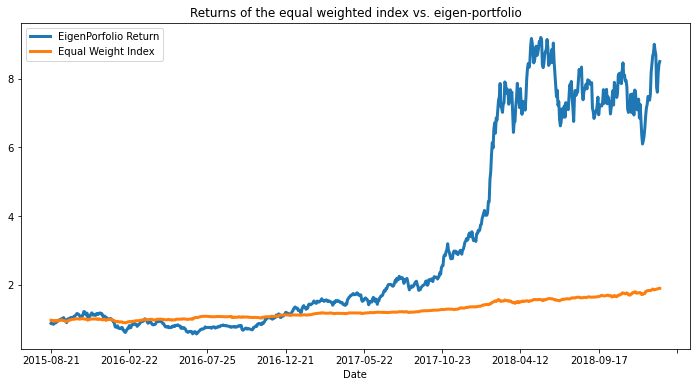

Current Eigen-Portfolio 5:
Return = 32.76%
Volatility = 68.64%
Sharpe = 0.48


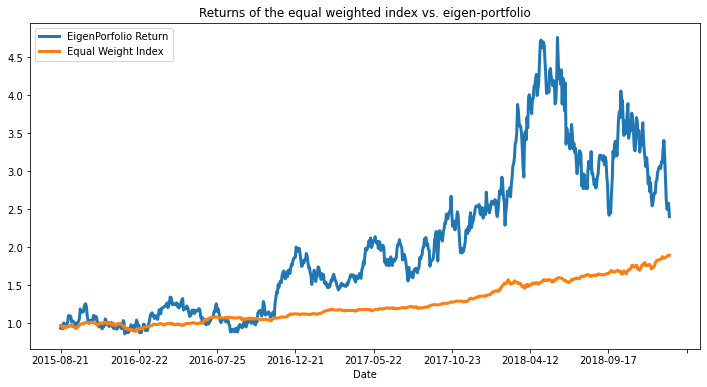

Current Eigen-Portfolio 2:
Return = -32.66%
Volatility = 76.12%
Sharpe = -0.43


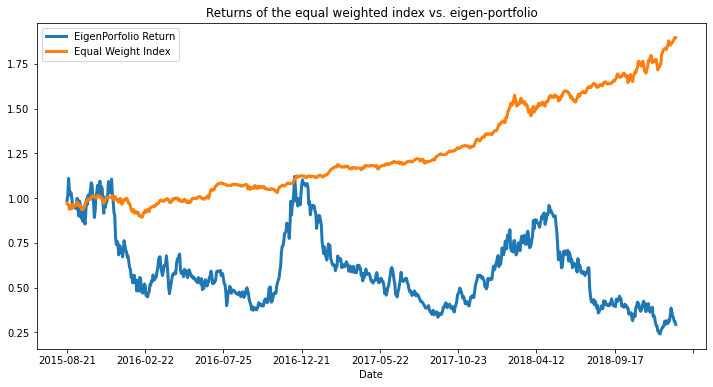

Current Eigen-Portfolio 14:
Return = -79.42%
Volatility = 185.30%
Sharpe = -0.43


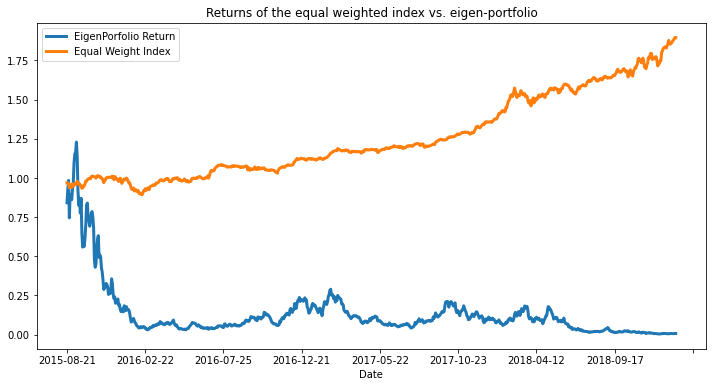

Current Eigen-Portfolio 0:
Return = 23.20%
Volatility = 11.27%
Sharpe = 2.06


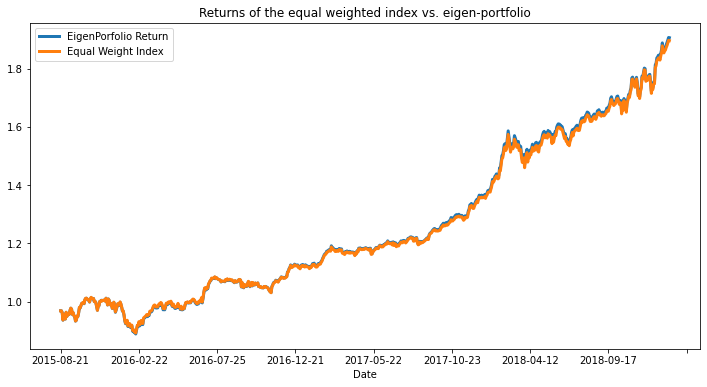

Current Eigen-Portfolio 7:
Return = -17.77%
Volatility = 53.47%
Sharpe = -0.33


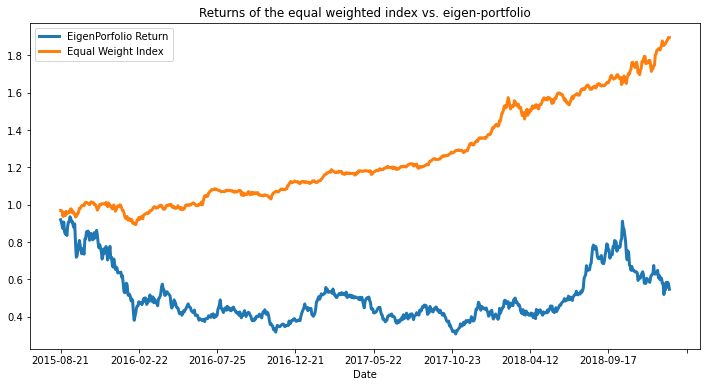

Current Eigen-Portfolio 11:
Return = -100.00%
Volatility = 584.42%
Sharpe = -0.17


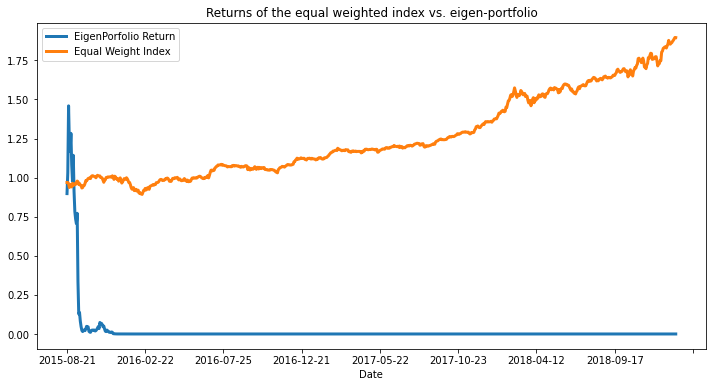

Current Eigen-Portfolio 13:
Return = 9.39%
Volatility = 143.48%
Sharpe = 0.07


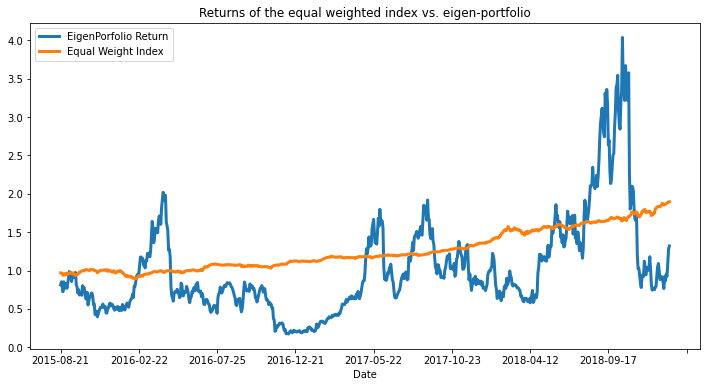

Current Eigen-Portfolio 25:
Return = -99.95%
Volatility = 418.62%
Sharpe = -0.24


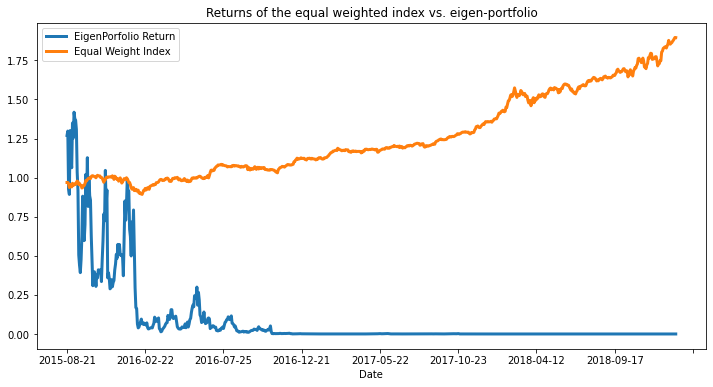

Current Eigen-Portfolio 23:
Return = -100.00%
Volatility = 451.20%
Sharpe = -0.22


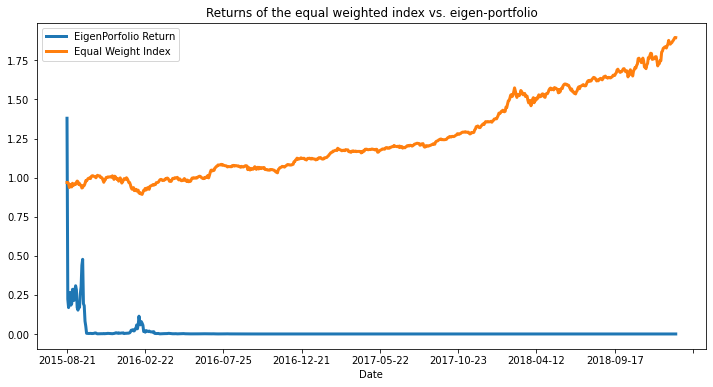

Current Eigen-Portfolio 6:
Return = -32.82%
Volatility = 152.78%
Sharpe = -0.21


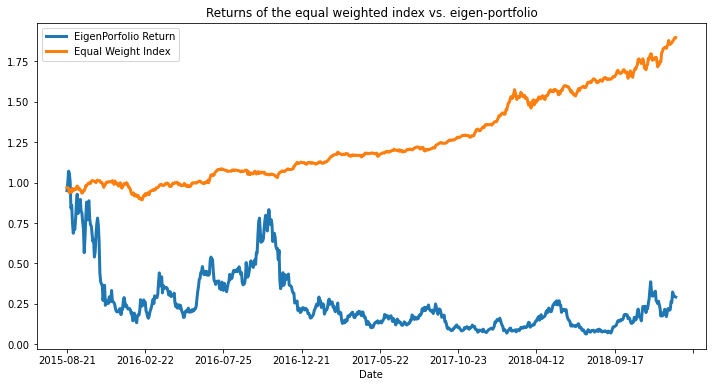

Current Eigen-Portfolio 10:
Return = 1.35%
Volatility = 63.94%
Sharpe = 0.02


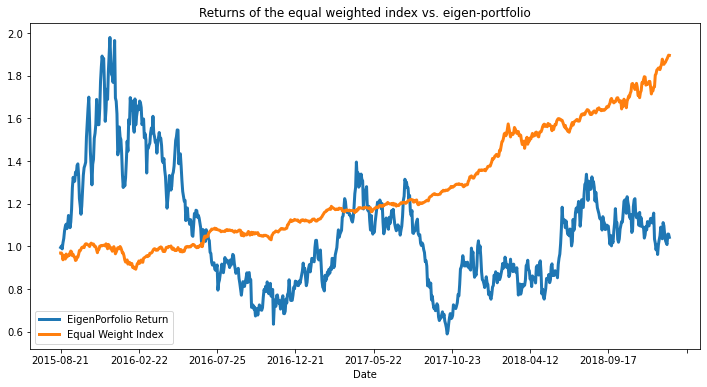

Current Eigen-Portfolio 3:
Return = -25.66%
Volatility = 67.31%
Sharpe = -0.38


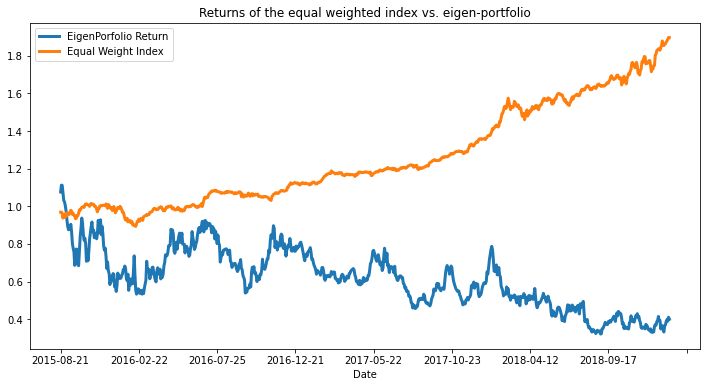

Current Eigen-Portfolio 26:
Return = -99.90%
Volatility = 311.45%
Sharpe = -0.32


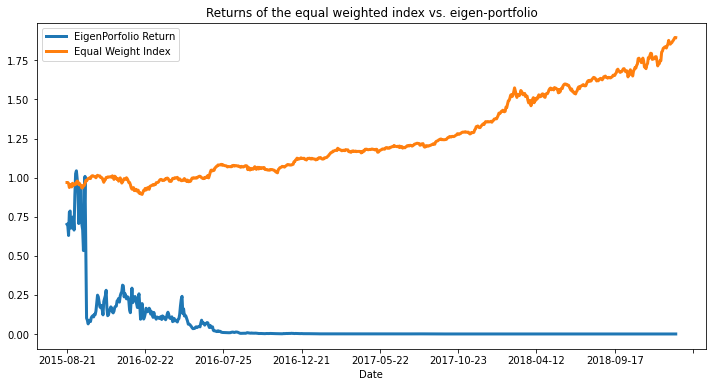

Current Eigen-Portfolio 8:
Return = -84.70%
Volatility = 119.50%
Sharpe = -0.71


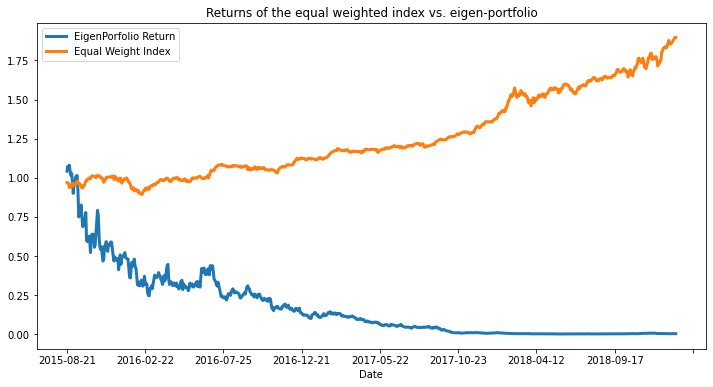

Current Eigen-Portfolio 17:
Return = -98.79%
Volatility = 254.48%
Sharpe = -0.39


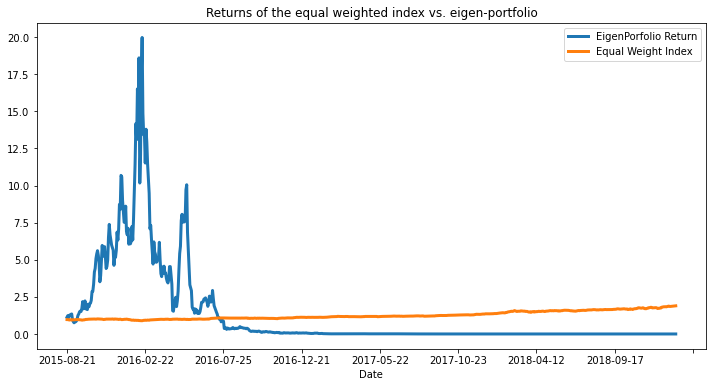

Current Eigen-Portfolio 24:
Return = -57.25%
Volatility = 128.90%
Sharpe = -0.44


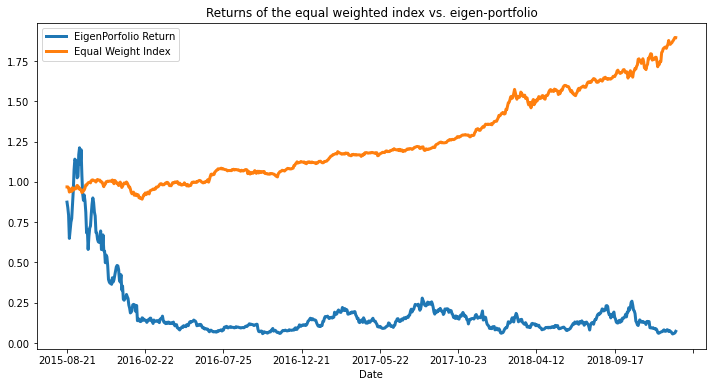

Current Eigen-Portfolio 16:
Return = -96.33%
Volatility = 221.43%
Sharpe = -0.44


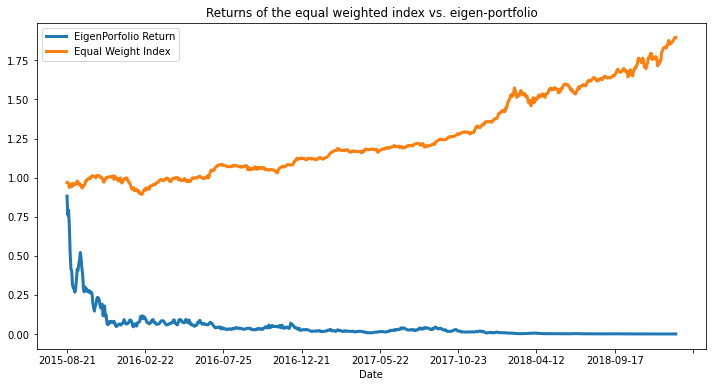

Current Eigen-Portfolio 21:
Return = -84.40%
Volatility = 103.40%
Sharpe = -0.82


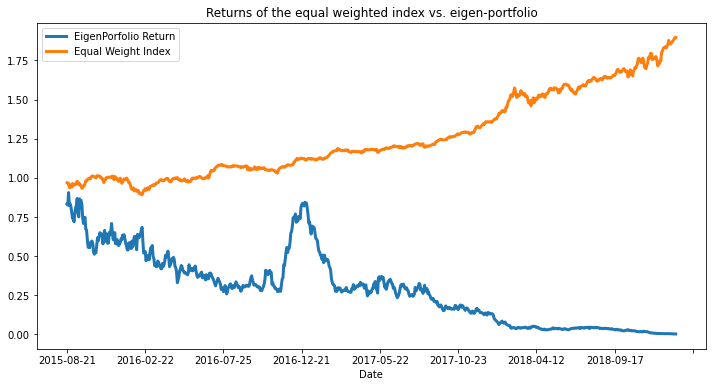

Current Eigen-Portfolio 27:
Return = 89.81%
Volatility = 206.53%
Sharpe = 0.43


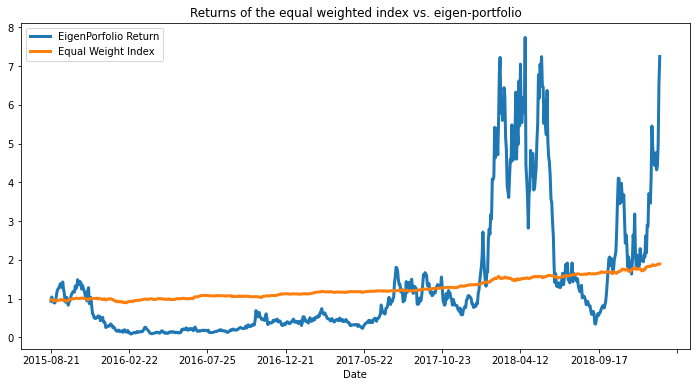

In [16]:
def Backtest(eigen, num):
    # Plots Principle components returns against real returns
    
    eigen_prtfi = pd.DataFrame(data ={'weights': eigen.squeeze()}, index = stock_tickers)
    eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)    

    eigen_prti_returns = np.dot(X_test_raw.loc[:, eigen_prtfi.index], eigen)
    eigen_portfolio_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_test_raw.index)
    returns, vol, sharpe = sharpe_ratio(eigen_portfolio_returns)  
    print('Current Eigen-Portfolio %d:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (num, returns*100, vol*100, sharpe))
    equal_weight_return=(X_test_raw * (1/len(pca.components_))).sum(axis=1)    
    df_plot = pd.DataFrame({'EigenPorfolio Return': eigen_portfolio_returns, 'Equal Weight Index': equal_weight_return}, index=X_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the equal weighted index vs. eigen-portfolio' , 
                          figsize=(12,6), linewidth=3)
    plt.show()

for i in [1,5,2,14,0,7,11,13,25,23,6,10,3,26,8,17,24,16,21,27]:
    Backtest(weights[i], i)